In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from time import time

In [ ]:
from GridWorld import GridWorld
from PolicyIteration import PolicyIteration

Let us initialize the problem and plot the problem

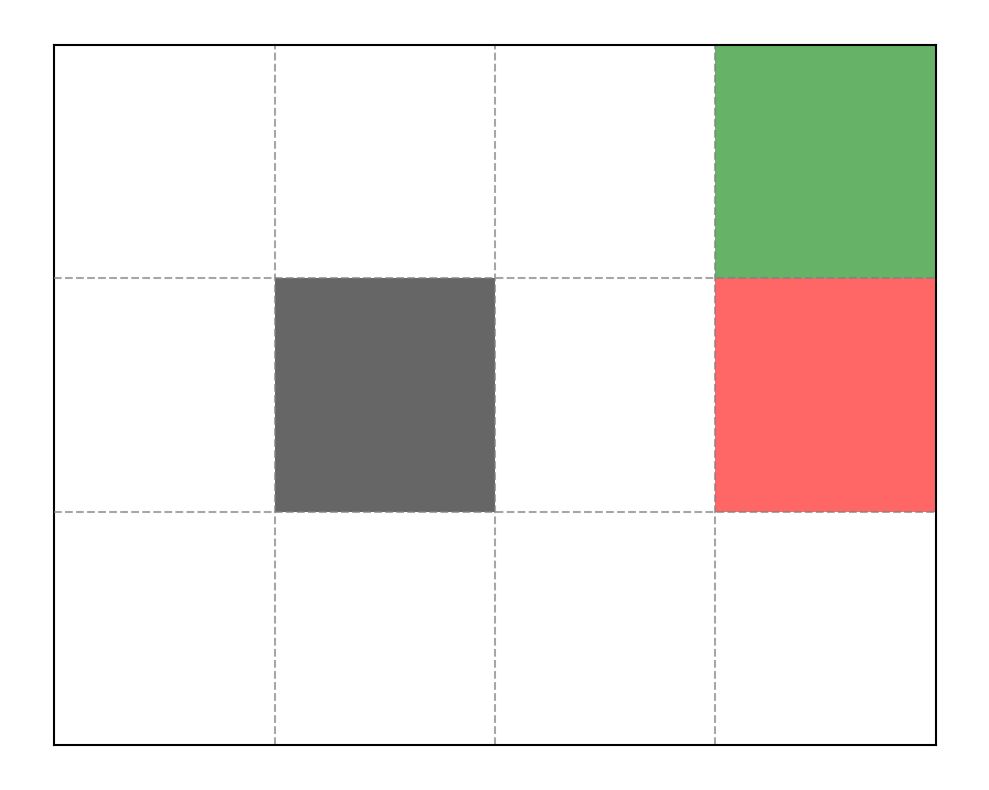

In [33]:
problem = GridWorld('data/world00.csv', reward={0: -0.04, 1: 1.0, 2: -1.0, 3: np.NaN}, random_rate=0.2)
#problem = GridWorld('data/world02.csv', reward={0: -0.04, 1: 10.0, 2: -10.0, 3: np.NaN}, random_rate=0.2)

problem.plot_map(fig_size=(10, 8))

# Random Policy

Let us initialize a random policy and plot it

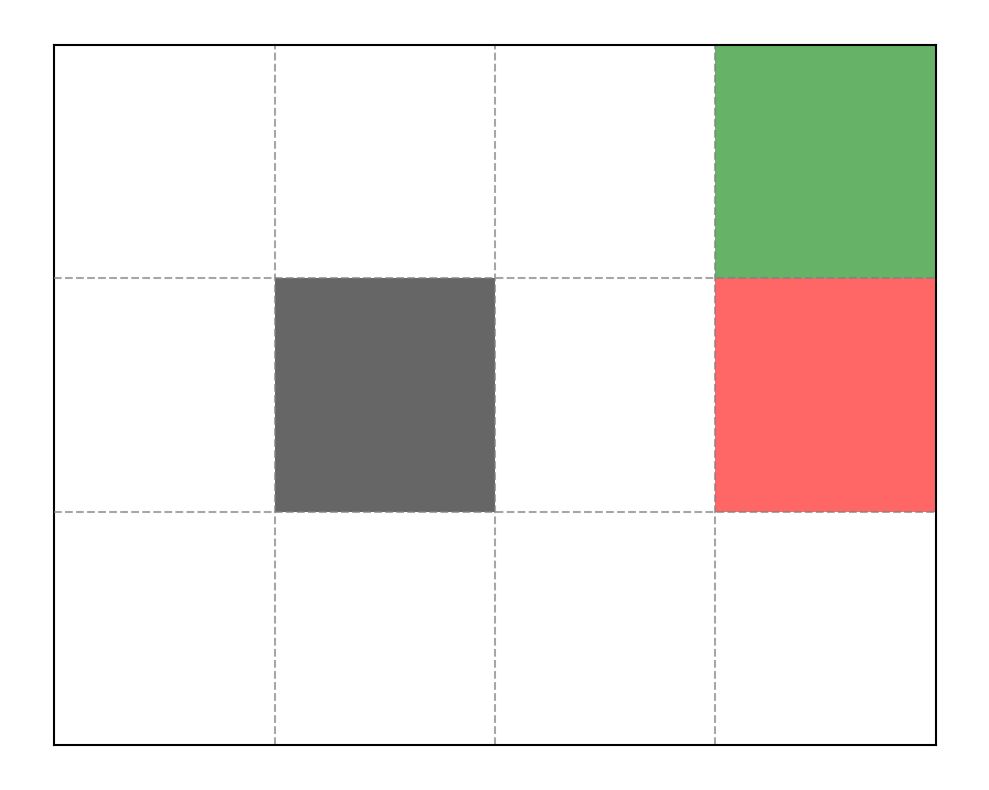

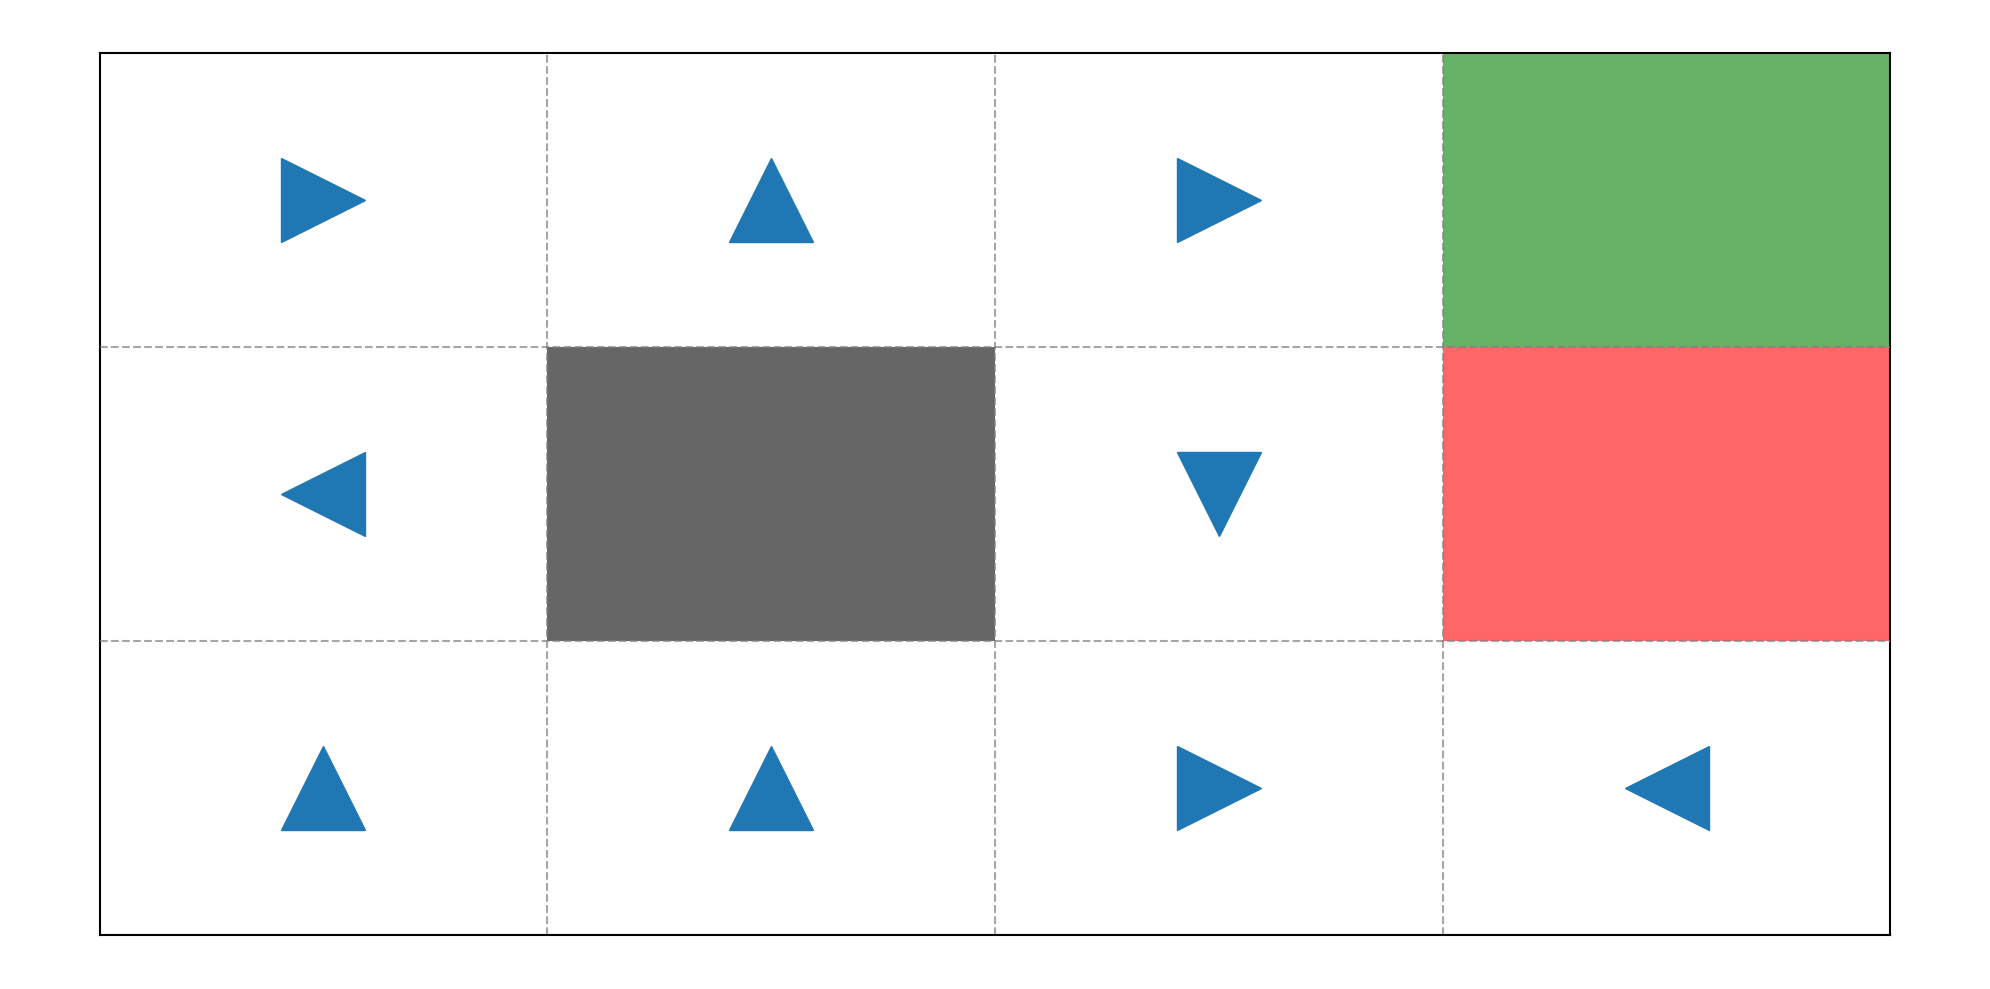

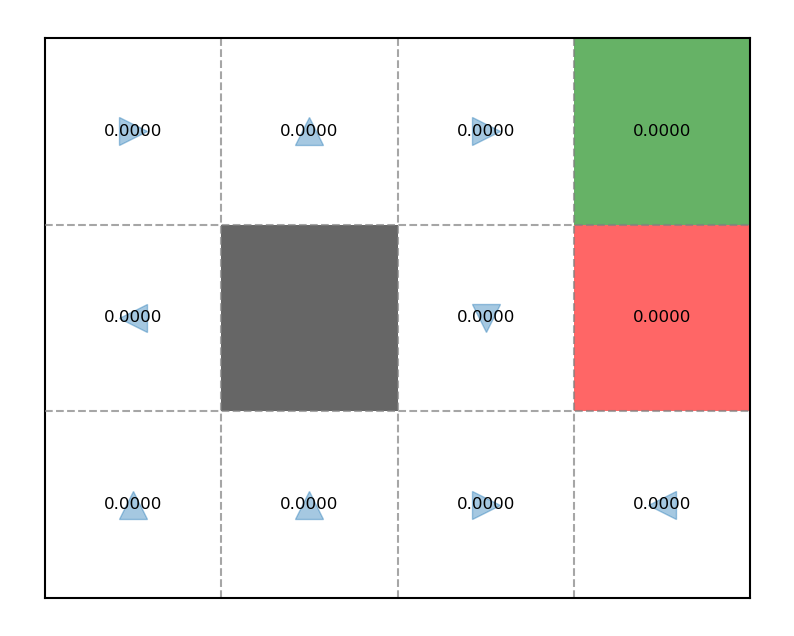

reward function =
State s = 0, Reward R(0) = -0.04
State s = 1, Reward R(1) = -0.04
State s = 2, Reward R(2) = -0.04
State s = 3, Reward R(3) = 1.0
State s = 4, Reward R(4) = -0.04
State s = 5, Reward R(5) = nan
State s = 6, Reward R(6) = -0.04
State s = 7, Reward R(7) = -1.0
State s = 8, Reward R(8) = -0.04
State s = 9, Reward R(9) = -0.04
State s = 10, Reward R(10) = -0.04
State s = 11, Reward R(11) = -0.04
transition model =
--------------------------------------
s = 0, a = 0, s' = 0, p = 0.9
s = 0, a = 0, s' = 1, p = 0.1
s = 0, a = 0, s' = 2, p = 0.0
s = 0, a = 0, s' = 3, p = 0.0
s = 0, a = 0, s' = 4, p = 0.0
s = 0, a = 0, s' = 5, p = 0.0
s = 0, a = 0, s' = 6, p = 0.0
s = 0, a = 0, s' = 7, p = 0.0
s = 0, a = 0, s' = 8, p = 0.0
s = 0, a = 0, s' = 9, p = 0.0
s = 0, a = 0, s' = 10, p = 0.0
s = 0, a = 0, s' = 11, p = 0.0
--------------------------------------
s = 0, a = 1, s' = 0, p = 0.1
s = 0, a = 1, s' = 1, p = 0.8
s = 0, a = 1, s' = 2, p = 0.0
s = 0, a = 1, s' = 3, p = 0.0
s = 0, a

In [31]:
# Generate a policy
init_policy = problem.generate_random_policy()

# Plot it
problem.plot_policy(init_policy, fig_size=(20, 10))

problem.visualize_value_policy(init_policy, np.zeros(problem.num_states), fig_size=(10, 8))

# Transition Probabilities 

reward_function = problem.reward_function
print(f'reward function =')
for s in range(len(reward_function)):
    print(f'State s = {s}, Reward R({s}) = {reward_function[s]}')

transition_model = problem.transition_model

print(f'transition model =')

for s in range(transition_model.shape[0]):
    print('======================================')
    for a in range(transition_model.shape[1]):
        print('--------------------------------------')
        for s_prime in range(transition_model.shape[2]):
            print(f's = {s}, a = {a}, s\' = {s_prime}, p = {transition_model[s, a, s_prime]}')
            

# Policy Iteration Algorithm

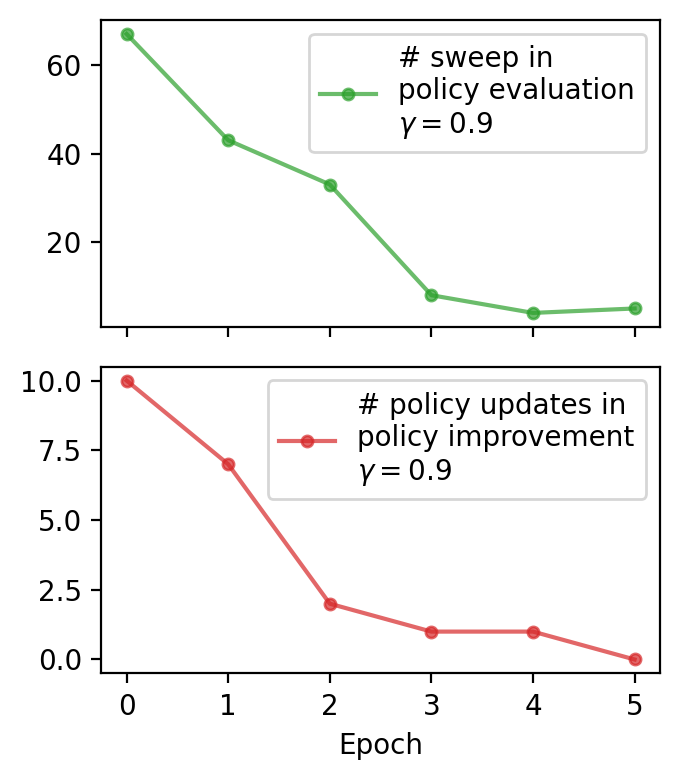

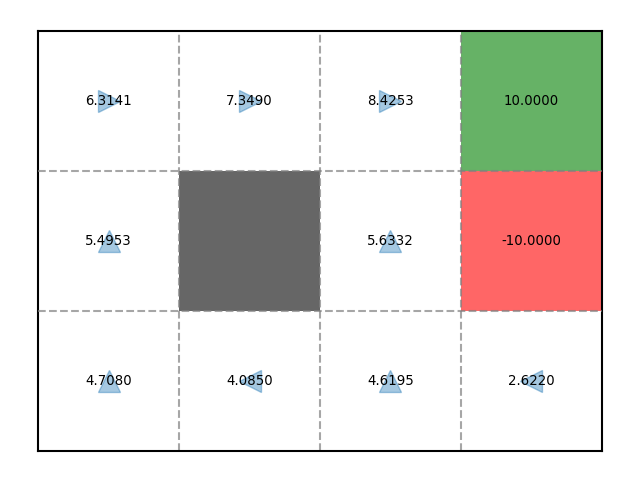

In [43]:
policy = [1, 1, 3, 1, 0, 0, 2, 0, 1, 2, 1, 0]

solver = PolicyIteration(problem.reward_function, problem.transition_model, gamma=0.9, init_policy=policy)
#solver = PolicyIteration(problem.reward_function, problem.transition_model, gamma=0.9)
solver.train()

problem.visualize_value_policy(policy=solver.policy, values=solver.values)

# Value Iteration Algorithm

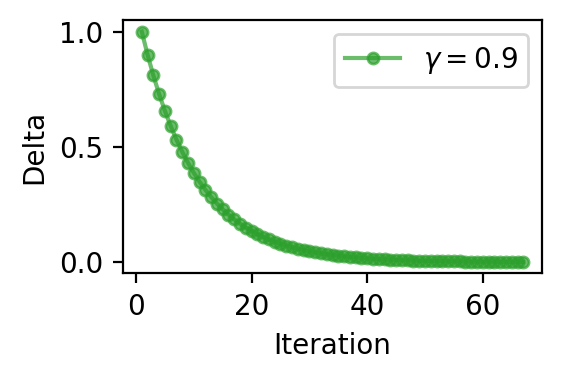

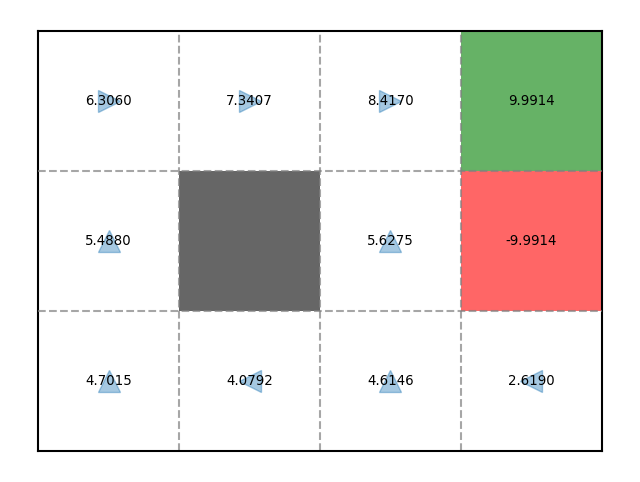

In [36]:
solver = ValueIteration(problem.reward_function, problem.transition_model, gamma=0.9)
solver.train()

problem.visualize_value_policy(policy=solver.policy, values=solver.values)

# Monte Carlo Algorithm

In [50]:
from MCLearner import MCLearner
from matplotlib.ticker import FormatStrFormatter

In [51]:
class GridWorldMCSolver:
    def __init__(self, problem, learner_class, epsilon=0.9, xi=0.99, initial_q=0.0):
        self.problem = problem
        self.learner = learner_class(num_states=problem.num_states, num_actions=problem.num_actions,
                                     epsilon=epsilon, xi=xi, initial_q=initial_q)

    def train_one_epoch(self, start_pos):
        s = self.problem.get_state_from_pos(start_pos)
        if_win = 0
        reward_game = 0
        time_start = int(round(time() * 1000))
        while True:
            a = self.learner.actuate(s)
            s_prime, r = self.problem.blackbox_move(s, a)
            self.learner.percept(s, a, s_prime, r)
            reward_game += r
            if r == self.problem.reward[1]:
                if_win = 1
                break
            elif r == self.problem.reward[2]:
                break
            else:
                s = s_prime
            if int(round(time() * 1000)) - time_start > 60000:
                print('Time out in this epoch!')
                break
        self.learner.policy_update()
        return reward_game, if_win

    def train(self, epochs, start_pos, plot=True):
        reward_history = np.zeros(epochs)
        total_reward_history = np.zeros(epochs)
        total_reward = 0
        game_win = np.zeros(epochs)

        time_start = int(round(time() * 1000))
        for i in range(epochs):
            print(f'Training epoch {i + 1}')
            reward_episode, win_episode = self.train_one_epoch(start_pos=start_pos)
            total_reward += reward_episode
            game_win[i] = win_episode
            reward_history[i] = reward_episode
            total_reward_history[i] = total_reward
        time_end = int(round(time() * 1000))
        print(f'time used = {time_end - time_start}')
        print(f'final reward = {total_reward}')

        # print('FINAL POLICY')
        # print(self.learner.cur_policy)
        # print('FINAL Q')
        # print(self.learner.q_table)
        # print('FINAL VALUE')
        # print(np.max(self.learner.q_table, axis=1))
        # print(f'game_win = {game_win}')
        segment = 10
        game_win = game_win.reshape((segment, epochs // segment))
        # print(f'game_win = {game_win}')
        game_win = np.sum(game_win, axis=1)
        # print(f'game_win = {game_win}')

        print(f'winning percentage = {game_win / (epochs // segment)}')

        if plot:
            fig, axes = plt.subplots(2, 1, figsize=(5, 4), dpi=200, sharex='all')
            axes[0].plot(np.arange(len(total_reward_history)), total_reward_history,
                         alpha=0.7, color='#d62728', label=r'$\xi$ = ' + f'{self.learner.xi}')
            axes[0].set_ylabel('Total rewards')
            axes[0].legend(loc='best')
            axes[1].plot(np.arange(len(reward_history)), reward_history, marker='o', markersize=2,
                         alpha=0.7, color='#2ca02c', linestyle='none')
            axes[1].set_xlabel('Episode')
            axes[1].set_ylabel('Reward from\na single game')
            # axes[1].set_ylim(-1000, 100)
            axes[1].xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
            axes[0].grid(axis='x')
            axes[1].grid(axis='x')
            plt.tight_layout()
            plt.show()

            fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=200)
            ax.plot(np.arange(1, segment + 1) * (epochs // segment), game_win / (epochs // segment), marker='o', markersize=2,
                    alpha=0.7, color='#2ca02c',
                    label=r'$\xi$ = ' + f'{self.learner.xi}')
            ax.set_ylabel('Winning percentage')
            ax.set_xlabel('Episode')
            plt.legend(loc='best')
            plt.tight_layout()
            plt.show()

        return total_reward

Training epoch 1
Training epoch 2
Training epoch 3
Training epoch 4
Training epoch 5
Training epoch 6
Training epoch 7
Training epoch 8
Training epoch 9
Training epoch 10
Training epoch 11
Training epoch 12
Training epoch 13
Training epoch 14
Training epoch 15
Training epoch 16
Training epoch 17
Training epoch 18
Training epoch 19
Training epoch 20
Training epoch 21
Training epoch 22
Training epoch 23
Training epoch 24
Training epoch 25
Training epoch 26
Training epoch 27
Training epoch 28
Training epoch 29
Training epoch 30
Training epoch 31
Training epoch 32
Training epoch 33
Training epoch 34
Training epoch 35
Training epoch 36
Training epoch 37
Training epoch 38
Training epoch 39
Training epoch 40
Training epoch 41
Training epoch 42
Training epoch 43
Training epoch 44
Training epoch 45
Training epoch 46
Training epoch 47
Training epoch 48
Training epoch 49
Training epoch 50
Training epoch 51
Training epoch 52
Training epoch 53
Training epoch 54
Training epoch 55
Training epoch 56
T

Training epoch 445
Training epoch 446
Training epoch 447
Training epoch 448
Training epoch 449
Training epoch 450
Training epoch 451
Training epoch 452
Training epoch 453
Training epoch 454
Training epoch 455
Training epoch 456
Training epoch 457
Training epoch 458
Training epoch 459
Training epoch 460
Training epoch 461
Training epoch 462
Training epoch 463
Training epoch 464
Training epoch 465
Training epoch 466
Training epoch 467
Training epoch 468
Training epoch 469
Training epoch 470
Training epoch 471
Training epoch 472
Training epoch 473
Training epoch 474
Training epoch 475
Training epoch 476
Training epoch 477
Training epoch 478
Training epoch 479
Training epoch 480
Training epoch 481
Training epoch 482
Training epoch 483
Training epoch 484
Training epoch 485
Training epoch 486
Training epoch 487
Training epoch 488
Training epoch 489
Training epoch 490
Training epoch 491
Training epoch 492
Training epoch 493
Training epoch 494
Training epoch 495
Training epoch 496
Training epo

Training epoch 881
Training epoch 882
Training epoch 883
Training epoch 884
Training epoch 885
Training epoch 886
Training epoch 887
Training epoch 888
Training epoch 889
Training epoch 890
Training epoch 891
Training epoch 892
Training epoch 893
Training epoch 894
Training epoch 895
Training epoch 896
Training epoch 897
Training epoch 898
Training epoch 899
Training epoch 900
Training epoch 901
Training epoch 902
Training epoch 903
Training epoch 904
Training epoch 905
Training epoch 906
Training epoch 907
Training epoch 908
Training epoch 909
Training epoch 910
Training epoch 911
Training epoch 912
Training epoch 913
Training epoch 914
Training epoch 915
Training epoch 916
Training epoch 917
Training epoch 918
Training epoch 919
Training epoch 920
Training epoch 921
Training epoch 922
Training epoch 923
Training epoch 924
Training epoch 925
Training epoch 926
Training epoch 927
Training epoch 928
Training epoch 929
Training epoch 930
Training epoch 931
Training epoch 932
Training epo

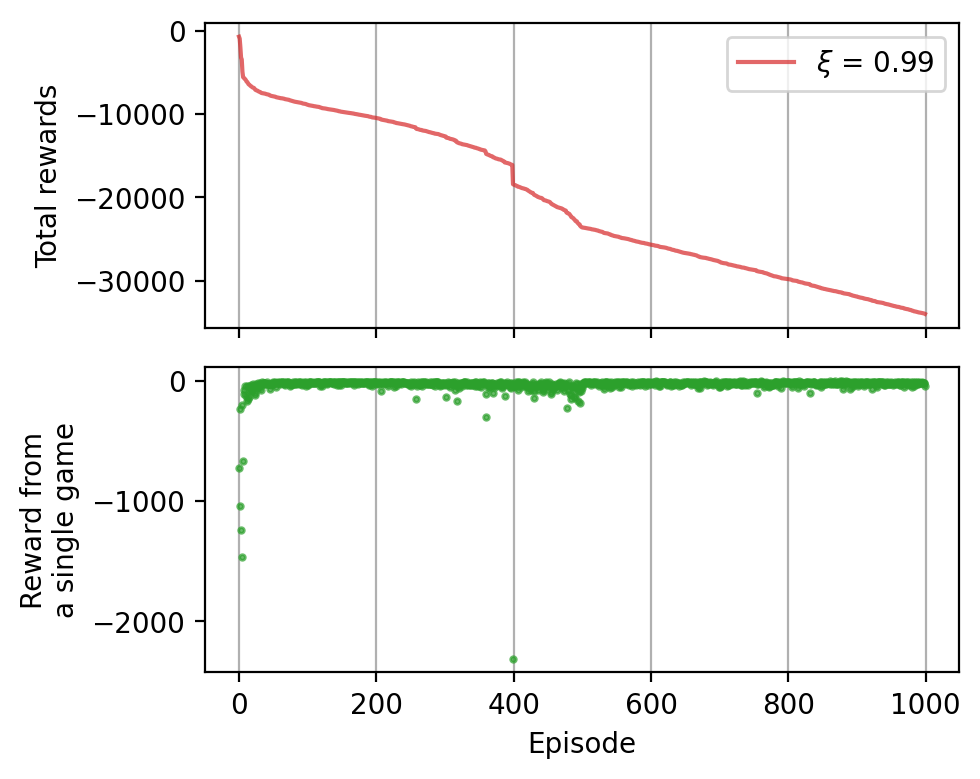

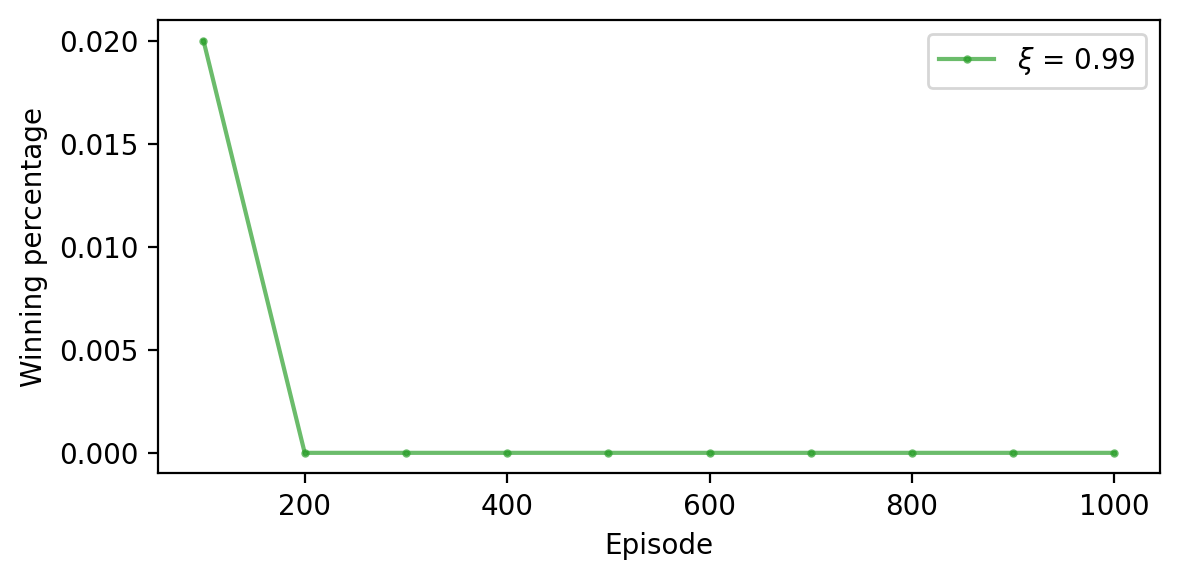

-33963.31999999666

In [52]:
np.random.seed(41)
problem = GridWorld('data/world02.csv', reward={0: -0.04, 1: 10.0, 2: -2.5, 3: np.NaN}, random_rate=0.2)

problem_solver = GridWorldMCSolver(problem, MCLearner, epsilon=1.0, xi=0.99, initial_q=0.0)
problem_solver.train(1000, start_pos=(5, 3), plot=True)

# Q-Learning

In [55]:
from QLearner import QLearner
from matplotlib.ticker import FormatStrFormatter

In [56]:
class GridWorldQSolver:
    
    def __init__(self, problem, learner_class, epsilon=0.9, xi=0.99):
        self.problem = problem
        self.learner = learner_class(num_states=problem.num_states, num_actions=problem.num_actions, epsilon=epsilon, xi=xi)

    def train_one_epoch(self, start_pos):
        
        s = self.problem.get_state_from_pos(start_pos)
        if_win = 0
        reward_game = 0
        while True:
            a = self.learner.actuate(s)
            s_prime, r = self.problem.blackbox_move(s, a)
            self.learner.percept(s, a, s_prime, r)
            reward_game += r
            if r == self.problem.reward[1]:
                if_win = 1
                break
            elif r == self.problem.reward[2]:
                break
            else:
                s = s_prime
        self.learner.update_episode()
        return reward_game, if_win

    def train(self, epochs, start_pos, plot=True):
        
        reward_history = np.zeros(epochs)
        total_reward_history = np.zeros(epochs)
        total_reward = 0
        game_win = np.zeros(epochs)

        time_start = int(round(time() * 1000))
        for i in range(epochs):
            print(f'Training epoch {i + 1}')
            reward_episode, win_episode = self.train_one_epoch(start_pos=start_pos)
            total_reward += reward_episode
            game_win[i] = win_episode
            reward_history[i] = reward_episode
            total_reward_history[i] = total_reward
        time_end = int(round(time() * 1000))
        print(f'time used = {time_end - time_start}')
        print(f'final reward = {total_reward}')

        segment = 10
        game_win = game_win.reshape((segment, epochs // segment))
        game_win = np.sum(game_win, axis=1)

        print(f'winning percentage = {game_win / (epochs // segment)}')

        if plot:
            fig, axes = plt.subplots(2, 1, figsize=(5, 4), dpi=200, sharex='all')
            axes[0].plot(np.arange(len(total_reward_history)), total_reward_history,
                         alpha=0.7, color='#d62728', label=r'$\xi$ = ' + f'{self.learner.xi}')
            axes[0].set_ylabel('Total rewards')
            axes[0].legend(loc='best')
            axes[1].plot(np.arange(len(reward_history)), reward_history, marker='o', markersize=2,
                         alpha=0.7, color='#2ca02c', linestyle='none')
            axes[1].set_xlabel('Episode')
            axes[1].set_ylabel('Reward from\na single game')
            # axes[1].set_ylim(-1000, 100)
            axes[1].xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
            axes[0].grid(axis='x')
            axes[1].grid(axis='x')
            plt.tight_layout()
            plt.show()

            fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=200)
            ax.plot(np.arange(1, segment + 1) * (epochs // segment), game_win / (epochs // segment), marker='o',
                    markersize=2,
                    alpha=0.7, color='#2ca02c',
                    label=r'$\xi$ = ' + f'{self.learner.xi}')
            ax.set_ylabel('Winning percentage')
            ax.set_xlabel('Episode')
            plt.legend(loc='best')
            plt.tight_layout()
            plt.show()

Training epoch 1
Training epoch 2
Training epoch 3
Training epoch 4
Training epoch 5
Training epoch 6
Training epoch 7
Training epoch 8
Training epoch 9
Training epoch 10
Training epoch 11
Training epoch 12
Training epoch 13
Training epoch 14
Training epoch 15
Training epoch 16
Training epoch 17
Training epoch 18
Training epoch 19
Training epoch 20
Training epoch 21
Training epoch 22
Training epoch 23
Training epoch 24
Training epoch 25
Training epoch 26
Training epoch 27
Training epoch 28
Training epoch 29
Training epoch 30
Training epoch 31
Training epoch 32
Training epoch 33
Training epoch 34
Training epoch 35
Training epoch 36
Training epoch 37
Training epoch 38
Training epoch 39
Training epoch 40
Training epoch 41
Training epoch 42
Training epoch 43
Training epoch 44
Training epoch 45
Training epoch 46
Training epoch 47
Training epoch 48
Training epoch 49
Training epoch 50
Training epoch 51
Training epoch 52
Training epoch 53
Training epoch 54
Training epoch 55
Training epoch 56
T

Training epoch 537
Training epoch 538
Training epoch 539
Training epoch 540
Training epoch 541
Training epoch 542
Training epoch 543
Training epoch 544
Training epoch 545
Training epoch 546
Training epoch 547
Training epoch 548
Training epoch 549
Training epoch 550
Training epoch 551
Training epoch 552
Training epoch 553
Training epoch 554
Training epoch 555
Training epoch 556
Training epoch 557
Training epoch 558
Training epoch 559
Training epoch 560
Training epoch 561
Training epoch 562
Training epoch 563
Training epoch 564
Training epoch 565
Training epoch 566
Training epoch 567
Training epoch 568
Training epoch 569
Training epoch 570
Training epoch 571
Training epoch 572
Training epoch 573
Training epoch 574
Training epoch 575
Training epoch 576
Training epoch 577
Training epoch 578
Training epoch 579
Training epoch 580
Training epoch 581
Training epoch 582
Training epoch 583
Training epoch 584
Training epoch 585
Training epoch 586
Training epoch 587
Training epoch 588
Training epo

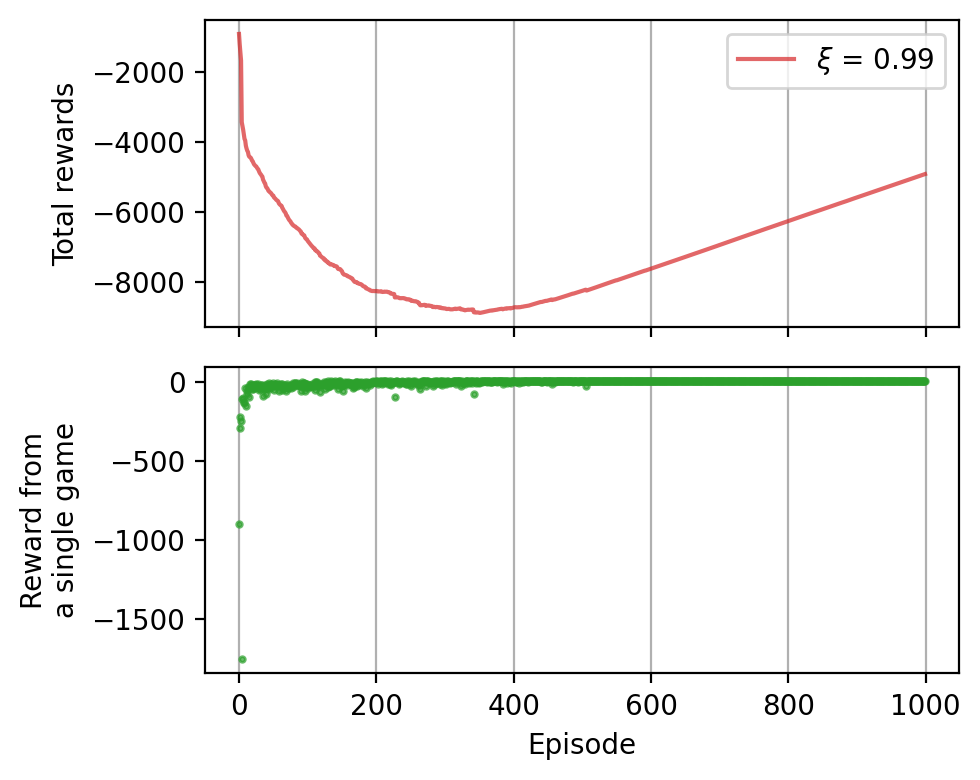

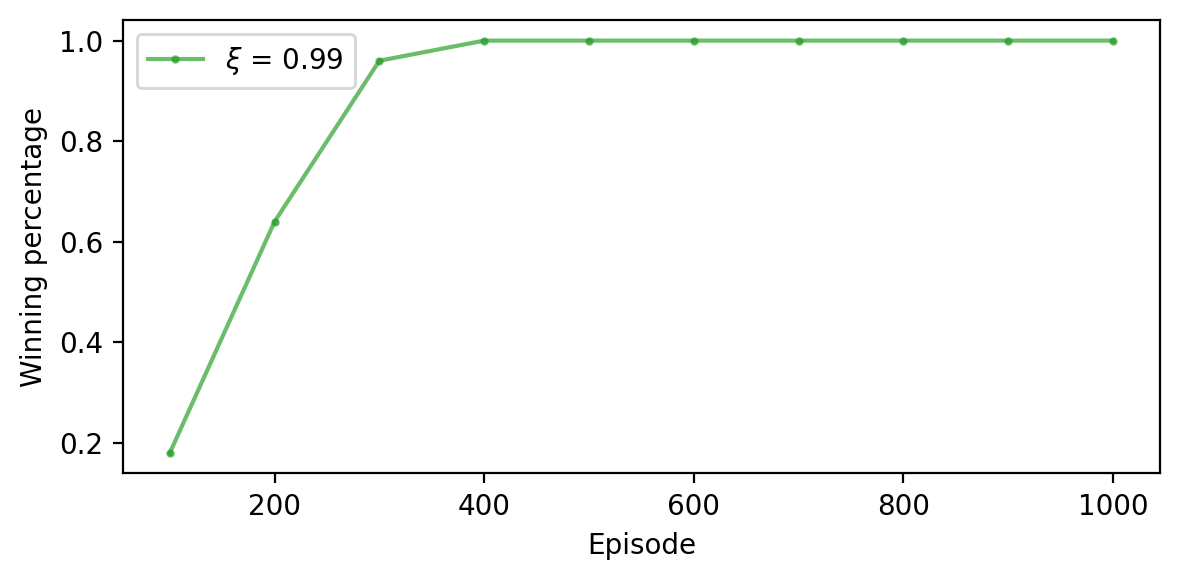

In [57]:
np.random.seed(42)

problem = GridWorld('data/world02.csv', reward={0: -0.04, 1: 10.0, 2: -2.5, 3: np.NaN}, random_rate=0.2)
problem_solver = GridWorldQSolver(problem, QLearner, epsilon=1.0, xi=0.99)
problem_solver.train(1000, start_pos=(5, 3), plot=True)

# Activity 2

Implementation of n-step SARSA (within the framework provided) for above pac-man problem. Your code should be professionally written, well integrated with existing code-base, as well as should be able to run on ‘data/world02.csv’ problem. 

# Activity 3

In this task, you are expected to code a solution for this problem using (two) RL algorithms — value iteration and Q-Learning that you completed in activity 2. Remember value iteration algorithm will require access to a transition probability which will be hard to get for TTT, as each player (your opponent) will have a different strategy.